In [1]:
# Setup
from __future__ import division
import matplotlib
import numpy as np
import scipy as sp
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import os
import progressbar
import sys

In [2]:
# Start an inference server

from venture.shortcuts import *
v = make_church_prime_ripl()

In [3]:
# Specify linear regression with clustered noise (i.e. not quite CLT noise)

def create_clustered_intercept_model(crp_alpha=0.3,
                                     offset_prior='(uniform_continuous -200 200)',
                                     reg_coef_prior='(uniform_continuous -10 10)',
                                     noise_sd_prior='(uniform_continuous 0.1 10)'):
    v.clear()

    v.assume("cluster_membership_crp", "(make_crp %f)" % crp_alpha)
    v.assume("cluster_membership", "(mem (lambda (index) (cluster_membership_crp)))")

    v.assume("intercept", "(mem (lambda (cluster_index) %s))" % offset_prior)
    v.assume("reg_coef", reg_coef_prior)
    v.assume("noise_sd", noise_sd_prior)

    v.assume("f", "(lambda (x index) (+ (intercept (cluster_membership index)) (* reg_coef x)))")

In [4]:
# Function to read CSV data

def load_data(filename='no_HC.csv'):
    mydata = pd.read_csv(os.path.join('..', 'data', filename), header=0) #python starts counting at zero
    X = mydata['mynewdata.FAI']
    Y = mydata['mynewdata.AQ']
    return X, Y

# Function to observe data

def observe_data(X, Y):
    for index, (x, y) in enumerate(zip(X, Y)):
        v.observe("(normal (f %f %d) noise_sd)" % (x, index), y)

In [5]:
# A function to do inference

def run_inference(n_data_points, n_samples=10, n_skip=10, n_burn=10):
    # Setup lists
    reg_coef_samples = []
    cluster_memberships_samples = []
    cluster_number_samples = []
    # Sample the cluster memberships...
    sample_clusters_string = '(list ' + ' '.join('(cluster_membership %d)' % index
                                                 for index in range(len(X))) + ')'
    # ... and the regression coefficient
    sampling_string = '(list reg_coef %s)' % sample_clusters_string
    # Burn
    for sample_i in range(n_burn):
        v.infer(n_skip)
        print(sample_i)
    # Sample
    for sample_i in range(n_samples):
        v.infer(n_skip)
        # Sample
        data = v.sample(sampling_string)
        reg_coef = data[0]
        cluster_memberships = data[1]
        # Make cluster memberships canonical
        cluster_numbers = np.unique(cluster_memberships)
        canonical_cluster_memberships = np.zeros(len(cluster_memberships))
        for i, value in enumerate(cluster_numbers):
            canonical_cluster_memberships[cluster_memberships==value] = i
        cluster_memberships = canonical_cluster_memberships
        # Count clusters
        cluster_number = len(cluster_numbers)
        # Save to lists
        reg_coef_samples.append(reg_coef)
        cluster_memberships_samples.append(cluster_memberships)
        cluster_number_samples.append(cluster_number)
        # Progress update
        print(sample_i)
    # Return
    return dict(reg_coef_samples=reg_coef_samples,
                cluster_memberships_samples=cluster_memberships_samples,
                cluster_number_samples=cluster_number_samples)

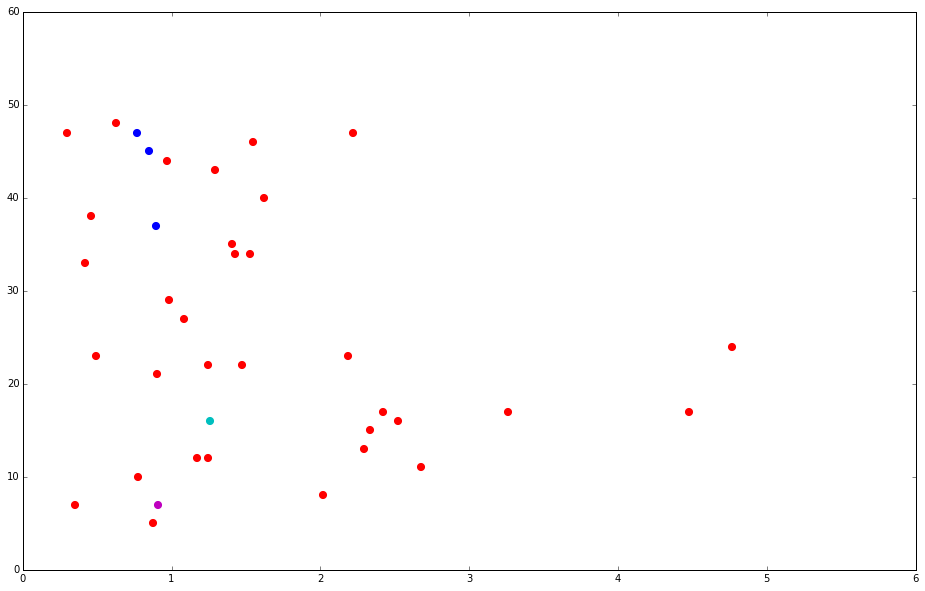

In [6]:
# Just to test - this should draw a picture

# Create default model, load default data and observe

create_clustered_intercept_model()
X, Y = load_data()
observe_data(X, Y)

# Sample the parameters and draw a picture

v.infer(1000)

fig, ax = plt.subplots(figsize=(16, 10))
plt.clf()

cluster_memberships = v.sample('(list ' + ' '.join('(cluster_membership %d)' % index
                                                   for index in range(len(X))) + ')')
cluster_numbers = np.unique(cluster_memberships)
canonical_cluster_memberships = np.zeros(len(cluster_memberships))
for i, value in enumerate(cluster_numbers):
    canonical_cluster_memberships[cluster_memberships==value] = i
cluster_memberships = canonical_cluster_memberships

for (cluster_index, x, y) in zip(cluster_memberships, X, Y):
    if cluster_index == 0:
        color = 'b'
    elif cluster_index == 1:
        color = 'r'
    elif cluster_index == 2:
        color = 'm'
    elif cluster_index == 3:
        color = 'c'
    else:
        color = 'k'
    plt.scatter(x, y, color=color, s=50)

In [7]:
# Define some analysis functions

def HDI_from_MCMC(posterior_samples, credible_mass):
    """
    Computes highest density interval from a sample of representative values,
    estimated as the shortest credible interval
    Takes Arguments posterior_samples (samples from posterior) and credible mass (normally .95)
    """
    sorted_points = sorted(posterior_samples)
    ciIdxInc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    nCIs = len(sorted_points) - ciIdxInc
    ciWidth = [0]*nCIs
    for i in range(0, nCIs):
        ciWidth[i] = sorted_points[i + ciIdxInc] - sorted_points[i]
    HDImin = sorted_points[ciWidth.index(min(ciWidth))]
    HDImax = sorted_points[ciWidth.index(min(ciWidth))+ciIdxInc]
    return HDImin, HDImax

def ACF_and_ESS(samples, corr='pearson', DEBUG=True):
    ACF = []
    for lag in range(1,int(np.floor(len(samples)/2))):
        result = []
        for row in range(lag,len(samples)): # Can't be more than the number of sample points taken
            result.append(samples[row])
        original = samples[:-lag]
        if corr == 'pearson':
            ACF.append(sp.stats.pearsonr(original,result)[0])
        elif corr == 'spearmanr':
            ACF.append(sp.stats.spearmanr(original,result)[0])
        else:
            raise Exception('Unrecognised correlation coefficient : %s' % corr)

    # Effective sample size
#     last_k =[ n for n,i in enumerate(ACF) if i<0.05 ][0]
    # TODO - more sensible number...
    last_k = min(50, len([_ for _ in ACF if not np.isnan(_)]))
    ACF_k = ACF[0:last_k]
    ESS = len(samples)/(1+(2*sum(ACF_k)))
    return ACF, ESS

def analyse_reg_coef(traces, prior=False, label='mog_same_width'):
    # For the regression coefficient, check the inference and summarise the posterior
    
    if prior:
        suffix = label + '_prior'
    else:
        suffix = label + '_posterior'    

    # Plot traces

    fig, ax = plt.subplots(figsize=(16, 10))
    plt.clf()

    for trace in traces:
        plt.plot(trace['reg_coef_samples'])

    plt.savefig(os.path.join('..', 'plots', 'reg_coef_traces_%s.pdf' % suffix))

    plt.show()

    # Estimate effective sample size

    total_ESS = 0

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    for i, trace in enumerate(traces):
        ACF, ESS = ACF_and_ESS(trace['reg_coef_samples'])
        total_ESS += ESS
        ax = fig.add_subplot(100 + 10 * len(traces) + (i + 1))
        ax.bar(left=range(len(ACF)), height=ACF)

    plt.savefig(os.path.join('..', 'plots', 'reg_coef_ACFs_%s.pdf' % suffix))

    plt.show()

    print('Total effective sample size = %d' % int(np.floor(total_ESS)))

    # Summarise posterior

    # With a histogram

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    combined_trace = []
    for trace in traces:
        combined_trace += trace['reg_coef_samples']

    plt.hist(combined_trace, bins=50)

    plt.savefig(os.path.join('..', 'plots', 'reg_coef_hist_%s.pdf' % suffix))

    plt.show()

    # And posterior mass above zero

    p_positive = len([coef for coef in combined_trace if coef > 0]) / len(combined_trace)
    print('Posterior probability of reg coef > 0 = %f' % p_positive)

    # And HDI

    for width in [0.95, 0.9, 0.8, 0.7, 0.5, 0.25]:
        HDI = HDI_from_MCMC(combined_trace, width)
        print('%02.0f%% highest density credible interval = [%f, %f]' % (width * 100, HDI[0], HDI[1]))
        
        
def reg_coef_sensitivity(traces, prior=False, label='mog_same_width'):
    if prior:
        suffix = label + '_prior'
    else:
        suffix = label + '_posterior'  
        
    # Show many histograms

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    axes = []

    for i, trace in enumerate(traces):
        if len(axes) == 0:
            axes.append(fig.add_subplot(10 + 100 * len(traces) + (i + 1)))
        else:
            axes.append(fig.add_subplot(10 + 100 * len(traces) + (i + 1), sharex=axes[0], sharey=axes[0]))
        axes[-1].hist(trace['reg_coef_samples'], bins=100)

    plt.savefig(os.path.join('..', 'plots', 'reg_coef_hist_sensitivity_%s.pdf' % suffix))

    plt.show()
    
def analyse_clusters(traces, prior=False, label='mog_same_width'):
    # TODO Instead of using histogram, use bar chart after calling np.bincount - more flexible for graphic making
    # counts = np.bincount(samples) 

    if prior:
        suffix = label + '_prior'
    else:
        suffix = label + '_posterior'  

    # Plot traces

    fig, ax = plt.subplots(figsize=(16, 10))
    plt.clf()

    for trace in traces:
        plt.plot(trace['cluster_number_samples'])

    plt.savefig(os.path.join('..', 'plots', 'cluster_number_traces_%s.pdf' % suffix))

    plt.show()

    # Estimate effective sample size

    total_ESS = 0

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    for i, trace in enumerate(traces):
        ACF, ESS = ACF_and_ESS(trace['cluster_number_samples'], corr='spearmanr')
        total_ESS += ESS
        ax = fig.add_subplot(100 + 10 * len(traces) + (i + 1))
        ax.bar(left=range(len(ACF)), height=ACF)

    plt.savefig(os.path.join('..', 'plots', 'cluster_number_ACFs_%s.pdf' % suffix))

    plt.show()

    print('Total effective sample size = %d' % int(np.floor(total_ESS)))

    # Summarise posterior

    # With a histogram

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    combined_trace = []
    for trace in traces:
        combined_trace += trace['cluster_number_samples']

    plt.hist(combined_trace, bins=len(np.unique(trace['cluster_number_samples'])))

    plt.savefig(os.path.join('..', 'plots', 'cluster_number_hist_%s.pdf' % suffix))

    plt.show()

    # And posterior mass above zero

    p_more_than_one_cluster = len([number for number in combined_trace if number > 1]) / len(combined_trace)
    print('Posterior probability of cluster number > 1 = %f' % p_more_than_one_cluster)

    # And HDI

    for width in [0.95, 0.9, 0.8, 0.7, 0.5, 0.25]:
        HDI = HDI_from_MCMC(combined_trace, width)
        print('%02.0f%% highest density credible interval = [%f, %f]' % (width * 100, HDI[0], HDI[1]))

    # Now clustering

    combined_trace = []
    for trace in traces:
        combined_trace += trace['cluster_memberships_samples']

    cluster_assignments = np.array(combined_trace)

    cluster_labels = np.unique(cluster_assignments)

    co_occurrence_matrix = np.zeros((cluster_assignments.shape[1], cluster_assignments.shape[1]))

    for label in cluster_labels:
        co_occurrence_matrix += np.dot((cluster_assignments.T == label) * 1, (cluster_assignments == label) * 1)


    # Reshape co-occurence_matrix by linkage
    reshaped = sch.linkage(co_occurrence_matrix)

    # print(co_occurrence_matrix)
    # print(co_occurrence_matrix.shape)

    # plt.clf()
    # fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

    # ax.imshow(co_occurrence_matrix, interpolation='nearest') #interpolation changes fuzzyness. try 'none' or 'nearest'
    # plt.show()

    co_occurrence_matrix = np.divide(co_occurrence_matrix, 10)

    # Reshape co-occurence_matrix by linkage
    linkage = sch.linkage(co_occurrence_matrix)
    dendrogram_right = sch.dendrogram(linkage, orientation='right')
    dendrogram = sch.dendrogram(linkage)
    idx1 = dendrogram_right['leaves']
    idx2 = dendrogram['leaves']
    co_occurrence_matrix = co_occurrence_matrix[idx1,:]
    co_occurrence_matrix = co_occurrence_matrix[:,idx2]

    # Co-occurrence matrix figure

    # plt.clf()
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    map=ax.imshow(co_occurrence_matrix, interpolation='nearest')
    plt.colorbar(map)
    plt.savefig(os.path.join('..', 'plots', 'co-occurrence_%s.pdf' % suffix)) # this line has to come before plt.show
    plt.show()

    # print(reshaped)
    # reshaped.shape

    # plt.clf()
    # fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    # ax.imshow(reshaped, interpolation='nearest') 
    # plt.savefig('co-occurrence.pdf') # this line has to come before plt.show
    # plt.show()
    
def cluster_sensitivity(traces, prior=False, label='mog_same_width'):
    if prior:
        suffix = label + '_prior'
    else:
        suffix = label + '_posterior'  
        
    # Show many histograms

    fig = plt.figure(figsize=(16, 10))
    plt.clf()

    axes = []

    for i, trace in enumerate(traces):
        if len(axes) == 0:
            axes.append(fig.add_subplot(10 + 100 * len(traces) + (i + 1)))
        else:
            axes.append(fig.add_subplot(10 + 100 * len(traces) + (i + 1), sharex=axes[0], sharey=axes[0]))
        axes[-1].hist(trace['cluster_number_samples'], bins=len(np.unique(trace['cluster_number_samples'])))

    plt.savefig(os.path.join('..', 'plots', 'cluster_number_hist_sensitivity_%s.pdf' % suffix))

    plt.show()

In [8]:
# Run inference with the standard model
# Set experiment parameters

DEBUG = False
if DEBUG:
    n_traces = 3
    n_samples = 100
    n_skip = 25
    n_burn = 10
else:
    n_traces = 5
    n_samples = 1000
    n_skip = 5000
    n_burn = 1000

# Load data

X, Y = load_data()

# Run inference several times - WITHOUT DATA - i.e. looking at the prior

traces_simple_prior = []
for _ in range(n_traces):
    # Create model
    create_clustered_intercept_model()
    # Observe data
#     observe_data(X, Y)
    # Collect trace
    traces_simple_prior.append(run_inference(n_data_points=len(Y), n_samples=n_samples, n_skip=n_skip, n_burn=n_burn))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [ ]:
# Summarise the prior - clusters

analyse_clusters(traces=traces_simple_prior, prior=True)

In [ ]:
# Summarise the prior - regression coefficient

analyse_reg_coef(traces=traces_simple_prior, prior=True)

In [ ]:
# Now run inference several times with data

traces_simple_posterior = []
for _ in range(n_traces):
    # Create model
    create_clustered_intercept_model()
    # Observe data
    observe_data(X, Y)
    # Collect trace
    traces_simple_posterior.append(run_inference(n_data_points=len(Y), n_samples=n_samples, n_skip=n_skip, n_burn=n_burn))

In [ ]:
# Summarise the posterior - clusters

analyse_clusters(traces=traces_simple_posterior, prior=False)

In [ ]:
# Summarise the posterior - regression coefficient

analyse_reg_coef(traces=traces_simple_posterior, prior=False)

In [ ]:
# Sensitivity analysis - CRP alpha - lower alpha means fewer clusters

# Set experiment parameters
if DEBUG:
    alphas = [0.033, 0.1, 0.3, 0.9, 2.7, 8.1, 24.3]
else:
    alphas = [0.033, 0.1, 0.3, 0.9, 2.7, 8.1, 24.3]

# Load data

X, Y = load_data()

In [ ]:
# Run inference several times without data

traces_simple_sensitivity_prior = []
for alpha in alphas:
    # Create model
    create_clustered_intercept_model(crp_alpha=alpha)
    # Observe data
#     observe_data(X, Y)
    # Collect trace
    traces_simple_sensitivity_prior.append(run_inference(n_data_points=len(Y), n_samples=n_samples, n_skip=n_skip, n_burn=n_burn))

In [ ]:
cluster_sensitivity(traces=traces_simple_sensitivity_prior, prior=True)

In [ ]:
reg_coef_sensitivity(traces=traces_simple_sensitivity_prior, prior=True)

In [ ]:
# Run inference several times with data

traces_simple_sensitivity_posterior = []
for alpha in alphas:
    # Create model
    create_clustered_intercept_model(crp_alpha=alpha)
    # Observe data
    observe_data(X, Y)
    # Collect trace
    traces_simple_sensitivity_posterior.append(run_inference(n_data_points=len(Y), n_samples=n_samples, n_skip=n_skip, n_burn=n_burn))

In [ ]:
cluster_sensitivity(traces=traces_simple_sensitivity_posterior, prior=False)

In [ ]:
reg_coef_sensitivity(traces=traces_simple_sensitivity_posterior, prior=False)

In [ ]:
# Now let's try an even more flexible model

# Specify linear regression with clustered noise and slight interactions with the clusterings

def create_fancy_model(crp_alpha='(uniform_continuous 0.1 20)',
                                     offset_prior='(uniform_continuous -200 200)',
                                     reg_coef_prior='(uniform_continuous -10 10)',
                                     reg_coef_variation_prior='(uniform_continuous -1 1)',
                                     noise_sd_prior='(uniform_continuous 0.1 10)'):
    v.clear()

    v.assume("cluster_membership_crp", "(make_crp %s)" % crp_alpha)
    v.assume("cluster_membership", "(mem (lambda (index) (cluster_membership_crp)))")

    v.assume("intercept", "(mem (lambda (cluster_index) %s))" % offset_prior)
    v.assume("reg_coef", reg_coef_prior)
    v.assume("cluster_reg_coef", "(mem (lambda (cluster_index) (+ reg_coef %s)))" % reg_coef_variation_prior)
    v.assume("noise_sd", "(mem (lambda (cluster_index) %s))" % noise_sd_prior)

    v.assume("f", "(lambda (x index) (+ (intercept (cluster_membership index)) (* (cluster_reg_coef (cluster_membership index)) x)))")
    
def observe_variable_noise_data(X, Y):
    for index, (x, y) in enumerate(zip(X, Y)):
        v.observe("(normal (f %f %d) (noise_sd %d))" % (x, index, index), y)

In [ ]:
# Run inference several times with data

if not DEBUG:
    n_skip = 50000

traces_fancy_posterior = []
for _ in range(n_traces):
    # Create model
    create_fancy_model()
    # Observe data
    observe_variable_noise_data(X, Y)
    # Collect trace
    traces_fancy_posterior.append(run_inference(n_data_points=len(Y), n_samples=n_samples, n_skip=n_skip, n_burn=n_burn))

In [ ]:
# Summarise

analyse_clusters(traces=traces_fancy_posterior, prior=False)
analyse_reg_coef(traces=traces_fancy_posterior, prior=False)